# Merging Customers Records Using Graphs in Python

## Introduction

Traditional relational databases and spreadsheets fall short in
capturing complex relationships among customers. Enter graph theory – a
powerful framework for representing and analyzing interconnected data.
By visualizing customer relationships as a graph, we can uncover hidden
patterns, identify clusters, and improve data quality.

## Motivation

Over time, customers records can become fragmented and duplicated. For
example, a customer may use multiple email addresses or phone numbers
when interacting with a company. Creating a new record for each email or
phone can lead to duplicate records for the same customer. This is
especially common in B2B scenarios, where customers often have multiple
representatives. Furthermore, some customers represent multiple
companies, and their records may be duplicated across different
companies.

Doing any type of marketing analysis on such dataset can lead to
incorrect results. We cannot be sure about the latest purchase, the
total amount spent, or the number of orders. Is this customer a loyal
one or not? Is that customer a new one or not? Is this customer going to
leave us or they just started buying from another company? Do we need to
send a discount to this customer or not? To answer these questions, we
need to have customers database defragmented and deduplicated.

Merging records manually can be time-consuming and error-prone. By using
graphs, we can represent the relationships between customers, emails,
and phones and find groups of connected customers. This can help us
identify duplicate records and perform actions depending on our business
logic.

## Sample Data

In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns


sns.set_style("white")

We have three datasets: `customers`, `emails`, and `phones.` Each
customer can have multiple emails and phones. The names, emails, and
phones are generated randomly and do not correspond to real people,
though the structure of the data is similar to what you might find in a
real-world scenario. In fact, it *is* the sample taken from the real
data, but the names and other personal information are generated
randomly to replace the actual ones.

In [2]:
customers = pd.read_csv("data/customers.csv")
emails = pd.read_csv("data/emails.csv")
phones = pd.read_csv("data/phones.csv")

Take a look at the data.

In [3]:
customers.head(3)

,customer_id,name
0,330087,William Sparks
1,443237,Joseph Williams
2,329867,Eddie Porter


In [4]:
print("Length:", len(customers), "Unique:", len(customers["customer_id"].unique()))

Length: 1000 Unique: 1000


In [5]:
emails.head(3)

,customer_id,email
0,599100,brian12@example.net
1,330087,emyers@example.com
2,25494,cindymurphy@example.net


In [6]:
print(
    "Length:",
    len(emails),
    "Unique:",
    len(emails["email"].unique()),
    "Duplicated:",
    sum(emails["email"].duplicated()),
    "Empty:",
    sum(emails["email"].isnull()),
)

Length: 957 Unique: 626 Duplicated: 331 Empty: 0


In [7]:
phones.head(3)

,customer_id,phone
0,15962,876.997.0254
1,99723,001-706-213-0362
2,99723,886.527.4420x90003


In [8]:
print(
    "Length:",
    len(phones),
    "Unique:",
    len(phones["phone"].unique()),
    "Duplicated:",
    sum(phones["phone"].duplicated()),
    "Empty:",
    sum(phones["phone"].isnull()),
)

Length: 855 Unique: 524 Duplicated: 331 Empty: 0


## Icons for Nodes

Next chunk of code creates a dictionary of icons for different types of
nodes in the graph. It will be used later to visualize the subgraphs.

In [9]:
import PIL

icons = {
    "customer": "icons/customer.png",
    "phone": "icons/phone.png",
    "email": "icons/email.png",
}

images = {k: PIL.Image.open(fname) for k, fname in icons.items()}

## Creating a Graph

Let's create graph and add nodes. Each node will represent a customer,
email, or phone. We will use the images dictionary to assign an image to
each node, but it's not necessary for the procedure, as well as setting
the type of the node.


In [10]:
G = nx.Graph()

nodes = []

for x in emails["email"].dropna().unique():
    G.add_node(x, image=images["email"], type="email")

for x in phones["phone"].dropna().unique():
    G.add_node(x, image=images["phone"], type="phone")

for x in customers["customer_id"].unique():
    G.add_node(x, image=images["customer"], type="customer")

Next, we will add edges to the graph. The edges will connect customers
with their emails and phones.

In [11]:
edges = []

for x in customers[["customer_id"]].merge(emails).values:
    edges.append(x)

for x in customers[["customer_id"]].merge(phones).values:
    edges.append(x)

G.add_edges_from(edges)

## Finding Groups of Connected Customers

Customers that share the same email or phone will be connected by the
edges. Let's find groups of connected customers.

In [12]:
groups = list(nx.connected_components(G))
print("Groups:", len(groups))

Groups: 559


## Visualizing the Graph

The number of connected components is rather large to visualize all of
them, and most of the groups will contain only a few nodes. Let's find
the groups with the largest number of nodes and visualize them.

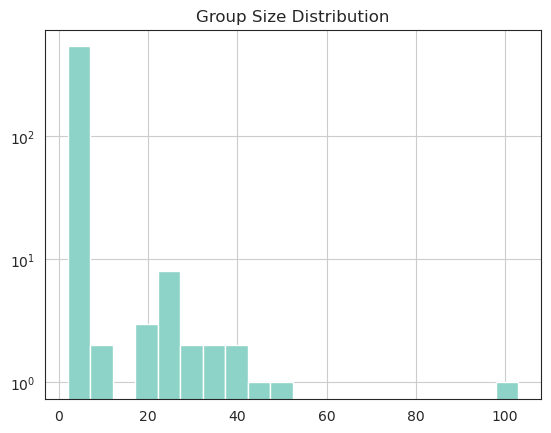

In [13]:
df = pd.DataFrame([groups]).T
df.columns = ["group"]
df["size"] = df["group"].apply(len)
df["size"].hist(bins=20, log=True)
plt.title("Group Size Distribution")
plt.show()
plt.close()

The simplest way to visualize the graph is to use the draw function from
the `networkx` library. We will use the `nx.draw` function to visualize
the graph. We will create a grid of subplots and visualize the top
groups. Parameter `seed` is set to 42 to make the layout reproducible.

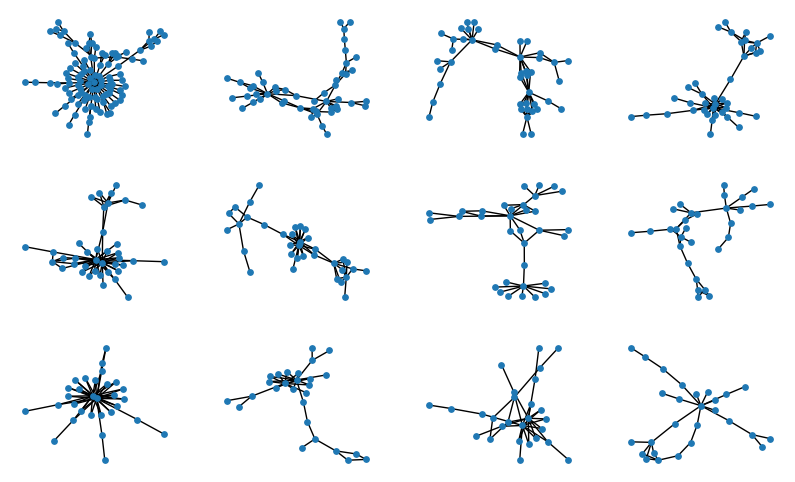

In [14]:
fig, axes = plt.subplots(3, 4, figsize=(10, 6))

top_groups = list(
    df.sort_values(
        "size",
        ascending=False,
    )
    .head(len(axes.flatten()))
    .index
)

for i, g in enumerate(top_groups):
    ax = axes.flatten()[i]
    subgraph = G.subgraph(groups[g])
    pos = nx.spring_layout(subgraph, seed=42)
    nx.draw(
        subgraph,
        pos=pos,
        with_labels=False,
        node_size=15,
        ax=ax,
    )
    # ax.set_title(f"Group {g}");

# plt.tight_layout()
plt.show()
plt.close()

There are literally constellations of different shapes and sizes. Let's
visualize some of them in more detail.

## Visualizing Subgraphs

Let's visualize one of the largest group in more detail. We will use the
`nx.draw_networkx_edges` function to draw the edges and the `imshow`
function to display the icons of the nodes. We will also add the
customer id to the customers' nodes. The value of parameter `seed` is
set to the same value as in the previous chunk to keep the layout. You
can change it to see different layouts.

/tmp/ipykernel_500819/4159731323.py:30: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  a.text(


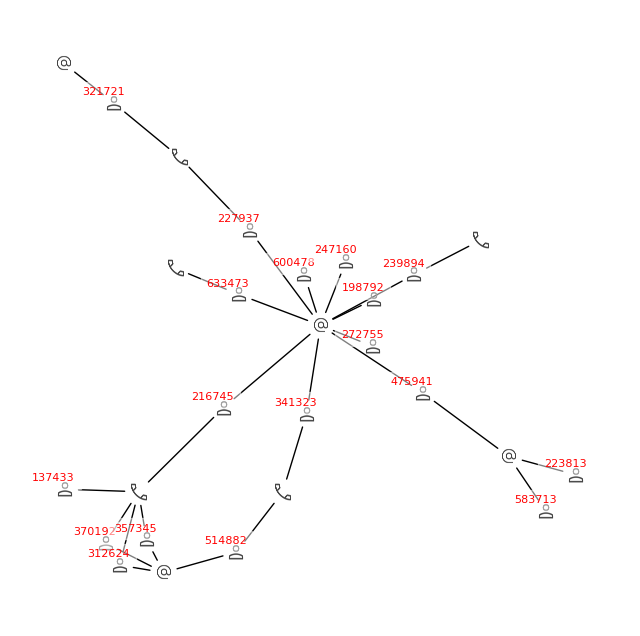

In [15]:
subgraph = G.subgraph(groups[91])
fig, ax = plt.subplots(figsize=(8, 8))

pos = nx.spring_layout(subgraph, seed=42)

nx.draw_networkx_edges(
    subgraph,
    pos=pos,
    ax=ax,
    arrows=True,
    arrowstyle="-",
    min_source_margin=10,
    min_target_margin=10,
)


tr_figure = ax.transData.transform
tr_axes = fig.transFigure.inverted().transform


icon_size = (ax.get_xlim()[1] - ax.get_xlim()[0]) * 0.015
icon_center = icon_size / 2.0

for n in subgraph.nodes:
    xf, yf = tr_figure(pos[n])
    xa, ya = tr_axes((xf, yf))
    a = plt.axes([xa - icon_center, ya - icon_center, icon_size, icon_size])
    a.imshow(subgraph.nodes[n]["image"])
    if G.nodes[n]["type"] == "customer":
        a.text(
            0.5,
            0.5,
            n,
            ha="center",
            va="center",
            fontsize=8,
            color="red",
            backgroundcolor="white",
            bbox=dict(color="white", facecolor="white", alpha=0.5),
        )
    a.axis("off")

sns.despine(left=True, bottom=True)

plt.show()
plt.close()

## Why Graphs and Not SQL?

We can see here that the customers in this group form pretty complex
relationships. A customer may be connected to another one by the phone
numbers, and the other one may be connected to the third one by the
email, forming a chain of connections. I believe that it is nearly
impossible to find this kind of relationship using SQL. The more complex
the relationships are, the more time and effort it will take to find
them using SQL. For example, if we have a chain of 10 customers, where
each customer is connected to the next one by the phone number, it will
take 10 joins to find this chain using SQL. If we have 100 customers in
the chain, it will take 100 joins to find it using SQL, and the query
will probably never complete. But it takes fractions of a second to find
it using the graph.

## Assigning Groups to Customers

Finally, we will assign a group to each customer. For that, we will
expand the groups list and create a new DataFrame with the `group_id`
and `customer_id` columns.

In [16]:
df = pd.DataFrame([groups]).T
df.columns = ["customer_id"]
df = df.explode("customer_id")
df["group_id"] = df.index
df.tail(3)

,customer_id,group_id
557,+1-385-321-0281,557
558,590385,558
558,571.212.7377x69843,558


Note that `customer_id` column contains phone numbers and emails as well
as customer ids, but when we merge the data, there will remain only the
customer ids.

In [17]:
customers = customers.merge(df)
customers.head(3)

,customer_id,name,group_id
0,330087,William Sparks,1
1,443237,Joseph Williams,4
2,329867,Eddie Porter,6


Let's check the number of customers and unique customer ids to make sure
that we didn't lose any customers neither we added duplicates.

In [18]:
len(customers), len(customers["customer_id"].unique())

(1000, 1000)

Looks good. Now we can save the data to the file.

In [19]:
customers.to_csv("data/customers_grouped.csv", index=False)

## Conclusion

In this article, we explored how to merge customer records using graphs.
We created a graph of customers, emails, and phones and found groups of
connected customers. We assigned a group to each customer and saved the
data to a file. This approach can help us identify duplicate records and
perform actions depending on our business logic. We also visualized the
graph and subgraphs to better understand the relationships between
customers. This can be useful for marketing analysis, customer
segmentation, and other tasks that require a deep understanding of
customer relationships.
